## Taller Redes Neuronales Convolucionales
##### Monitor: Juan Nicolas Piedrahita Salas

#### Introducción a la inteligencia artificial 2023-02

este dataset contiene imagenes satelitales, en las cuales se encuentran imagenes: de nubes, de desierto, areas verdes, y de agua. El objetivo es poder predecir una imagen a que clase pertenece.

link del dataset: https://drive.google.com/file/d/1GP5dvkiDK5Pd6zzJdDUrNdbugVRNNK0u/view?usp=sharing

# 1. importar librerias

### conectar con google drive

es recomendable subir los datasets a google drive, ya que algunos tendran una gran cantidad de imagenes que se demoran en subir mucho (asi ocupen poco espacio)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# 2. cargar imagenes

In [ ]:
"""
carga imagenes desde un directorio que contiene carpetas con las imagenes pertenecientes a cada clase

    Args:
        directorio: directorio de la carpeta de imagenes
        img_size: tupla que contiene las dimensiones con las que sean cargadas las imagenes
        color_mode: modo de color de las imagenes ("grayscale", "rgb", "rgba")

    Returns:
        X: numpy array que contiene las imagenes
        y: numpy array de los labels de las imagenes
"""
def Cargar_img(directorio: str, img_size: tuple[int, int], color_mode: str):
    import tensorflow as tf
    import numpy as np
    from os import listdir
    import os

    X, y = [], []
    class_names = listdir(directorio)
    for i, img_fold in enumerate(class_names):

        images_path = listdir(os.path.join(directorio, img_fold))
        y.extend([i]*len(images_path))
        for img_name in images_path:
            image = tf.keras.utils.load_img(
                os.path.join(directorio, img_fold, img_name),
                color_mode = color_mode,
                target_size= img_size,
                interpolation="nearest",
                keep_aspect_ratio=False,
            )

            image = tf.keras.utils.img_to_array(image, data_format="channels_last").astype(np.uint8)

            X.append(image)

    print("clases encontradas:", class_names)
    X = np.array(X)
    y = np.array(y)

    i = np.arange(0, y.shape[0])
    np.random.shuffle(i)

    return X[i], y[i]

In [ ]:
X, y = Cargar_img(
    directorio = "/content/drive/MyDrive/MATERIAS/2023-1/Monitoria IA/Diapositivas/TALLER 7 - Deep Learning - redes neuronales/data",
    img_size = (128,128),
    color_mode = "rgb"
)

clases encontradas: ['cloudy', 'desert', 'green_area', 'water']


In [ ]:
X = np.load("/content/drive/MyDrive/MATERIAS/2023-1/Monitoria IA/Diapositivas/TALLER 7 - Deep Learning - redes neuronales/X.npy")
y = np.load("/content/drive/MyDrive/MATERIAS/2023-1/Monitoria IA/Diapositivas/TALLER 7 - Deep Learning - redes neuronales/y.npy")

# 3. Exploracion de datos

In [ ]:
clases = ['cloudy', 'desert', 'green_area', 'water']

### dimensiones del dataset

- en la primera dimension tenemos la cantidad de imagenes (osea tenemos 5631 imagenes)

- en la segunda y tercera dimension tenemos el alto y ancho de cada imagen (tenemos imagenes de 128x128 pixeles)

- en la 4 dimension tenemos la cantidad de canales de color (en este caso como tenemos imagenes en rgb, tenemos los 3 canales de color del rgb, si tuvieramos imagenes en escala de grises, tendriamos un solo canal, y en caso de tener imagenes en rgba tendriamos los 4 canales de color de rgba)

In [ ]:
X.shape

(5631, 128, 128, 3)

### ejemplos de imagenes por clase

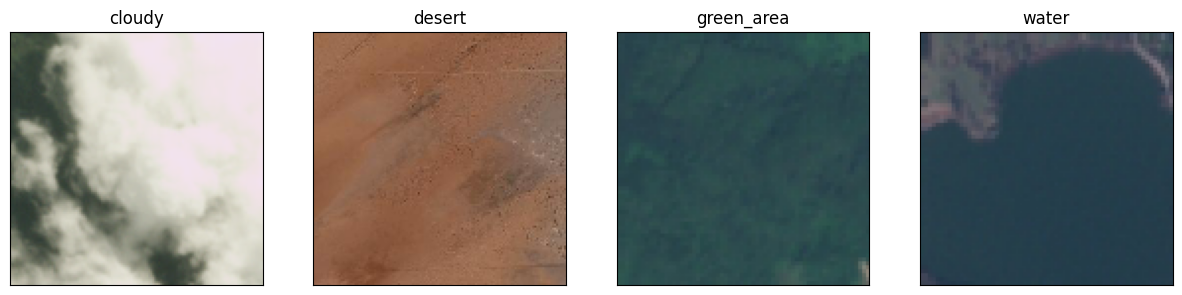

In [ ]:
_, axes = plt.subplots(1, 4, figsize=(15,15))
for i in range(len(clases)):
    axes[i].imshow(X[ y == i ][0])
    axes[i].set_title(clases[i])

    axes[i].xaxis.set_tick_params(labelbottom=False)
    axes[i].yaxis.set_tick_params(labelleft=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()

### cantidad de imagenes por clase

en este caso vemos que la clase desert esta levemente desbalanceada, lo que podria causar un desempeño peor al clasificar esta clase, en este caso no se balancearan las clases ya que el desbalanceo no es muy exagerado.

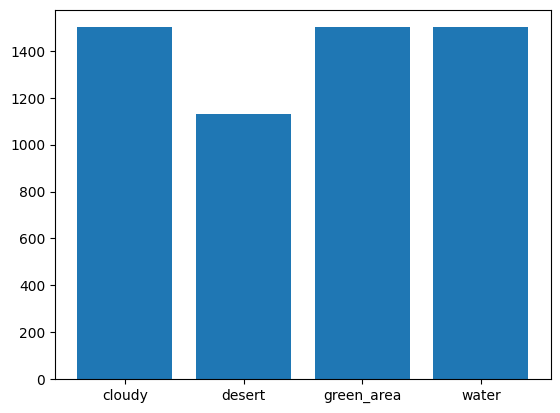

In [ ]:
plt.figure()

plt.bar(clases, np.bincount(y))

plt.show()

en caso de requerir balancear las clases, se puede hacer mediante data augmentation (se deja funcion para realizar data augmentation para balancear clases), sin embargo hay que tener en cuenta que el proceso de data augmentation puede que nos de imagenes de peor calidad.

tambien podemos pasarle los pesos de cada clase al momento de entrenar al modelo con el parametro `class_weight`, al igual que haciamos en DT

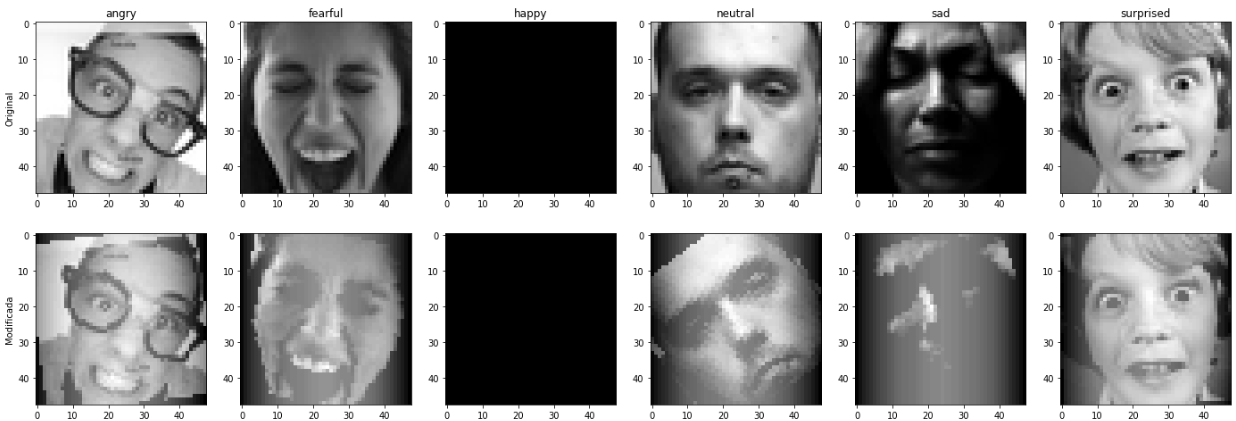

In [ ]:
# Data augmentation: balanceo de clases
# Entrada: X, y, clases
# Salida: X_aug, y_aug
# X: matriz de imagenes de entrenamiento
# y: vector de etiquetas de entrenamiento
# clases: vector de etiquetas de clases
# seed: semilla para las funciones aleatorias

# antes de usar se debe instalar tensorflow_addons, corriendo el siguiente comando:
# !pip install tensorflow_addons

def data_aug_balanceo(X, y, clases, seed = 1):
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import tensorflow_addons as tfa

    fig, (org_axes, aug_axes) = plt.subplots(2, len(clases), figsize=(24,8))

    max_cls = np.max(np.bincount(y))    # clase con mas imagenes
    for cls in np.unique(y):
        org_axes[cls].set_title(clases[cls])

        img_generar = max_cls - y[ y == cls ].size  # imagenes a generar

        if img_generar > 0:
            rango = np.where(y == cls)[0]   # indices de todas las imagenes de la clase

            np.random.seed(seed)
            selected = np.random.choice(rango, size=img_generar)    # indices de las imagenes seleccionadas al azar que seran aumentadas
            imgs_selected = X[selected].copy()                      # imagenes seleccionadas

            # rotar imagenes
            imgs_augmented = np.array([tfa.image.rotate(imgs_selected[i], np.random.uniform(-45, 45, 1) * np.pi/180) for i in range(img_generar)])

            # brillo aleatorio
            imgs_augmented = tf.image.stateless_random_brightness(imgs_augmented, max_delta=0.35, seed=(seed, seed))

            # contraste aleatorio
            imgs_augmented = tf.image.stateless_random_contrast(imgs_augmented, 0.2, 0.5, seed=(seed, seed))

            # concatenar imagenes con el resto del dataset
            imgs_augmented = np.asarray(imgs_augmented)
            X = np.concatenate((X, imgs_augmented), axis=0)
            y = np.concatenate((y, [cls]*img_generar), axis=0)

            # mostrar imagenes originales y aumentadas
            org_axes[cls].imshow(imgs_selected[0], cmap="gray")
            aug_axes[cls].imshow(imgs_augmented[0], cmap="gray")

        else:
            # para la clase mayoritaria se muestra un recuadro negro
            org_axes[cls].imshow(np.zeros((X[0].shape[0], X[0].shape[1])), cmap="gray")
            aug_axes[cls].imshow(np.zeros((X[0].shape[0], X[0].shape[1])), cmap="gray")

    org_axes[0].set_ylabel("Original")
    aug_axes[0].set_ylabel("Modificada")

    plt.grid(False)
    plt.show()

    return X, y

# 4. preprocesamiento

### escalar datos del rango [0, 255] al rango [0, 1]

esto es necesario ya que el dominio de la funcion de perdida es [0,1], en caso de que le pasemos valores fuera de este rango, la funcion de perdida nos devolvera NaN y el modelo no se entrenara

In [ ]:
X_scaled = X / 255

### separacion de imagenes en entrenamiento y prueba

cuando entrenamos un modelo de deep learning se hacen 3 divisiones al dataset original:
- entrenamiento: datos usados para entrenar la red
- Validacion: datos usados para optimizar los parametros de la red
- prueba: datos usados para evaluar el rendimiento de la red sobre datos nuevos

<img src="https://i.stack.imgur.com/pXAfX.png" width=550, height=250>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, stratify=y)

### data augmentation

aplicar transformaciones aleatorias a nuestro dataset con el fin de a partir de una misma imagen, obtener otras imagenes para entrenar nuestro modelo

In [ ]:
train_data_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 45,    # rotar imagenes hasta 45 grados aleatoriamente
    shear_range=0.2,        # mover la imagen para formar un paralelogramo, hasta en un 20% aleatoriamente
    zoom_range=0.2,         # aplicar zoom hasta del 20% aleatoriamente
    horizontal_flip=True,   # rotar horizontalmente la imagen aleatoriamente
    validation_split=0.25   # fraccion de las imagenes que seran usadas para validar el modelo
)

# 5. Creacion y entrenamiento del modelo

creamos el modelo, añadiendo capaz a este, para este modelo se usaron las siguientes capaz:

- Conv2D:

    capa que aplica un kernel 2D de convolucion a las imagenes, recibe como parametros, cantidad de filtros (kernels), tamaño de los filtros, funcion de activacion
- maxPooling2D:

    capa que toma el maximo valor de una matriz 2D de tamaño especificado
- Flatten:

    capa que transforma inputs 2D, en un solo vector 1D (espaguettisamos el input)
- Dense:

    capa que cuenta con una cantidad de neuronas especificadas, las cuales aplican la funcion de activacion especificada
- Dropout:

    capa que "apaga" una fraccion especificada de las neuronas en cada epoch, ayuda a evitar el sobreajuste del modelo

pueden consultar todas las capas que ofrece keras en https://keras.io/api/layers/

In [ ]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(128, 128, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(clases), activation='softmax')  # ultima capa, nos da la clasificacion final del modelo, debe tener tantas neuronas como clases en el dataset
])

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       7

### compilar y entrenar

#### compilacion:
- para la compilacion se usara el algoritmo de optimizacion ADAM

- la funcion de perdida sera `sparse_categorical_crossentropy`, que se define como:


> <img src="https://miro.medium.com/v2/resize:fit:640/0*vteMfTAGWsIZSaOW">

- la metrica que se usara para medir el desempeño del modelo sera el `accuracy`

#### callbacks

se definen los siguiente callbacks para el modelo:
- EarlyStopping: cuando el modelo deje de "mejorar", se detendra su entrenamiento

pueden encontrar mas callbacks en https://keras.io/api/callbacks/

#### entrenamiento

In [ ]:
# Compilacion
modelo.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
CB = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
]

# Entrenamiento
history = modelo.fit(
    train_data_augmenter.flow(X_train, y_train, subset="training"),
    validation_data = train_data_augmenter.flow(X_train, y_train, subset="validation"),
    epochs = 60,
    callbacks = CB,
    batch_size = 32,
    validation_batch_size = 32
)

Epoch 1/60
106/106 [==============================] - 33s 186ms/step - loss: 0.6251 - accuracy: 0.6859 - val_loss: 0.4092 - val_accuracy: 0.8073
Epoch 2/60
106/106 [==============================] - 18s 170ms/step - loss: 0.4911 - accuracy: 0.7842 - val_loss: 0.3477 - val_accuracy: 0.8472
Epoch 3/60
106/106 [==============================] - 21s 200ms/step - loss: 0.3870 - accuracy: 0.8319 - val_loss: 0.3358 - val_accuracy: 0.8837
Epoch 4/60
106/106 [==============================] - 20s 185ms/step - loss: 0.4197 - accuracy: 0.8156 - val_loss: 0.3122 - val_accuracy: 0.8748
Epoch 5/60
106/106 [==============================] - 21s 195ms/step - loss: 0.4186 - accuracy: 0.8218 - val_loss: 0.4007 - val_accuracy: 0.8739
Epoch 6/60
106/106 [==============================] - 19s 182ms/step - loss: 0.3904 - accuracy: 0.8393 - val_loss: 0.3186 - val_accuracy: 0.8783
Epoch 7/60
106/106 [==============================] - 18s 172ms/step - loss: 0.4241 - accuracy: 0.8215 - val_loss: 0.4210 - val_ac

### Visualizar filtros

podemos ver los filtros que las capas convolucionales le aplican a la imagen para extraer sus caracteristicas

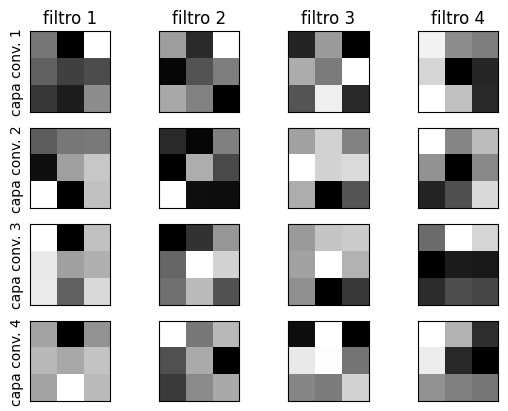

In [ ]:
# filtrar capas convolucionales
conv_layers = [layer for layer in modelo.layers if "conv" in layer.name ]

np.random.seed(1)

_, axes = plt.subplots(len(conv_layers), 4)

for i, layer in enumerate(conv_layers):
    axes[i,0].set_ylabel(f"capa conv. {i+1}")
    axes[0,i].set_title(f"filtro {i+1}")

    # obtener los filtros de cada capa convolucional
    filters, biases = layer.get_weights()
    # reescalar filtros para poder ser visualizados
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # obtener 4 filtros al azar para ser visualizados
    sel = np.random.randint(0, filters.shape[-1], 4)
    filters_selected = filters[:,:,:, sel]
    filters_selected = np.moveaxis(filters_selected, -1, 0)
    filters_selected = np.mean(filters_selected, axis=3, keepdims=True)
    # filters_selected = filters_selected[:,:,:,0]
    for j, filter in enumerate(filters_selected):
        # visualizar filtro
        axes[i,j].imshow(filter, cmap="gray")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.show()

### visualizar los filtros aplicados a las imagenes (Feature Maps)

tambien podemos ver las imagenes resultantes de aplicarles los filtros anteriormente vistos. Por ejemplo:

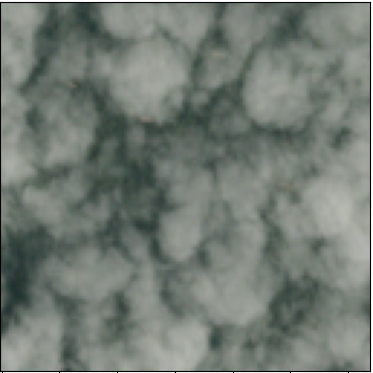

(algunas imagenes resultantes son oscuras y no muestran nada en particular, esto puede ser debido a que el filtro en particular que se le aplico a esa imagen, no pudo extraer ninguna caracteristica, por ejemplo si tenemos un filtro que detecta lineas verticales, y tenemos una imagen compuesta de solo lineas horizontales, dicho filtro no podra extraer informacion de esa imagen)

1/1 [==============================] - 0s 239ms/step


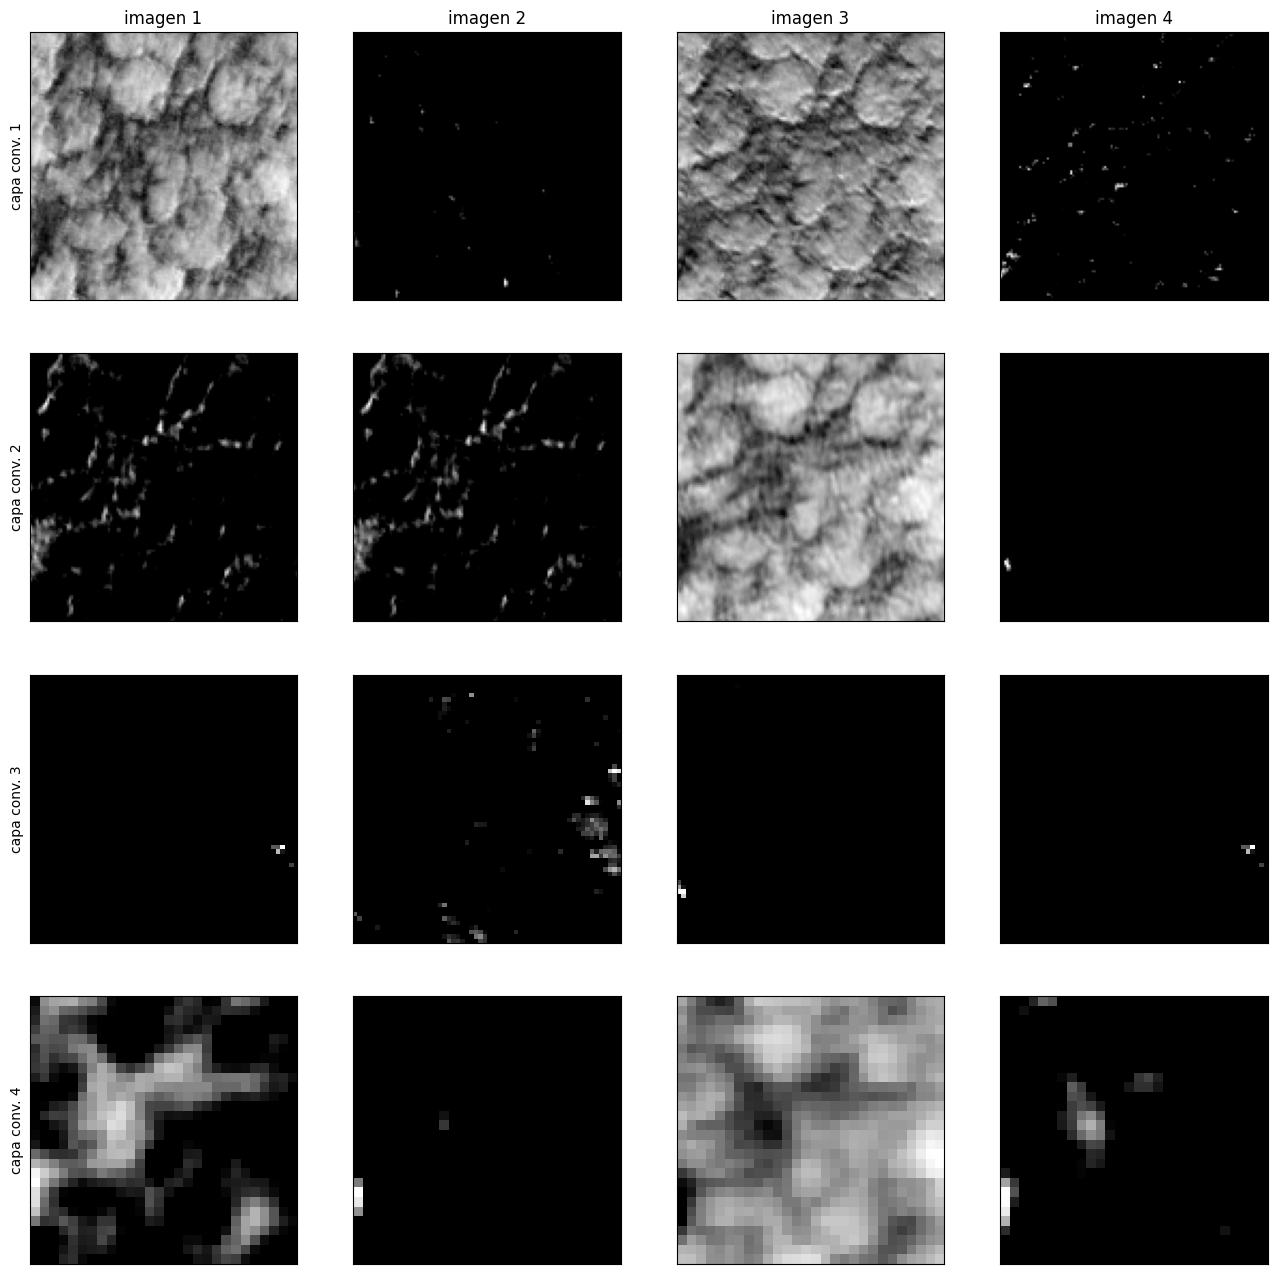

In [ ]:
_, axes = plt.subplots(len(conv_layers), 4, figsize=(16,16))

np.random.seed(3)

# modelo que nos dara la salida de cada capa convolucional
vis_model = tf.keras.models.Model(
    inputs = modelo.input,
    outputs = [ layer.output for layer in conv_layers ]
)

# aplicar el modelo hasta cada capa convolucional
feature_maps = vis_model.predict( np.expand_dims(X_test[40], axis=0) )

for i, f_map in enumerate(feature_maps):
    axes[i,0].set_ylabel(f"capa conv. {i+1}")
    axes[0,i].set_title(f"imagen {i+1}")

    # filtrar imagenes resultantes sin caracteristicas extraidas
    f_map = f_map[:,:,:, np.any(f_map[0,:,:,:] > 0, axis=(0,1)) ]

    # seleccionar 4 imagenes con el filtro aplicado para mostrar
    sel = np.random.randint(0, f_map.shape[-1], 4)
    feature_map_selected = f_map[:,:,:, sel]
    feature_map_selected = feature_map_selected[0]
    feature_map_selected = np.moveaxis(feature_map_selected, -1, 0)
    for j, image in enumerate(feature_map_selected):
        # visualizar imagen
        axes[i,j].imshow(image, cmap="gray")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.show()

# 6. analisis de resultados

### graficar evolucion en cada epoch del accuracy y la funcion de perdida durante el entrenamiento

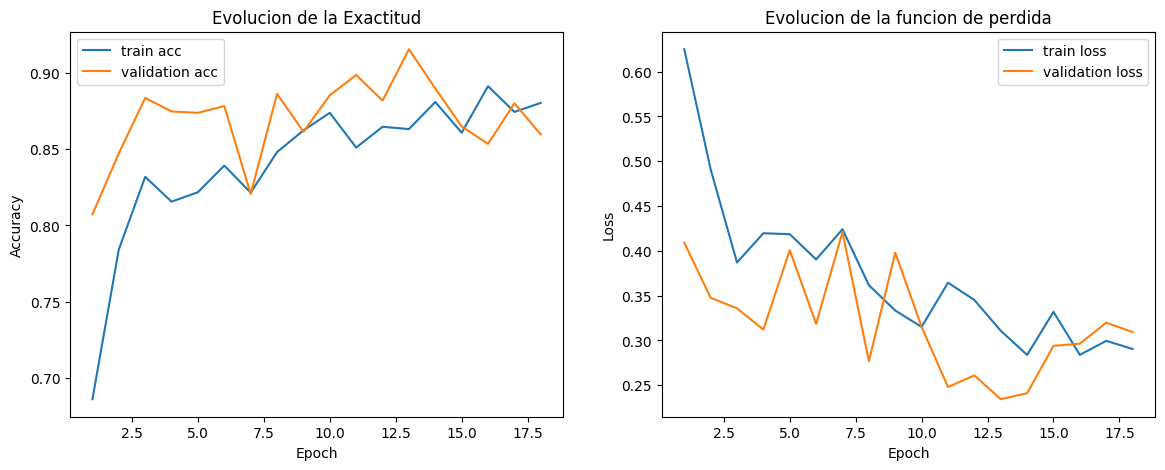

In [ ]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

### graficar matrices de confusion y reporte de metricas


ENTRENAMIENTO Y VALIDACION:

141/141 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1200
           1       0.92      0.95      0.93       904
           2       0.88      0.93      0.90      1200
           3       0.90      0.88      0.89      1200

    accuracy                           0.91      4504
   macro avg       0.91      0.91      0.91      4504
weighted avg       0.91      0.91      0.91      4504


PRUEBA:

36/36 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       300
           1       0.92      0.95      0.93       227
           2       0.88      0.92      0.90       300
           3       0.88      0.88      0.88       300

    accuracy                           0.91      1127
   macro avg       0.91      0.91      0.91      1127
weighted avg       0.91      0.91  

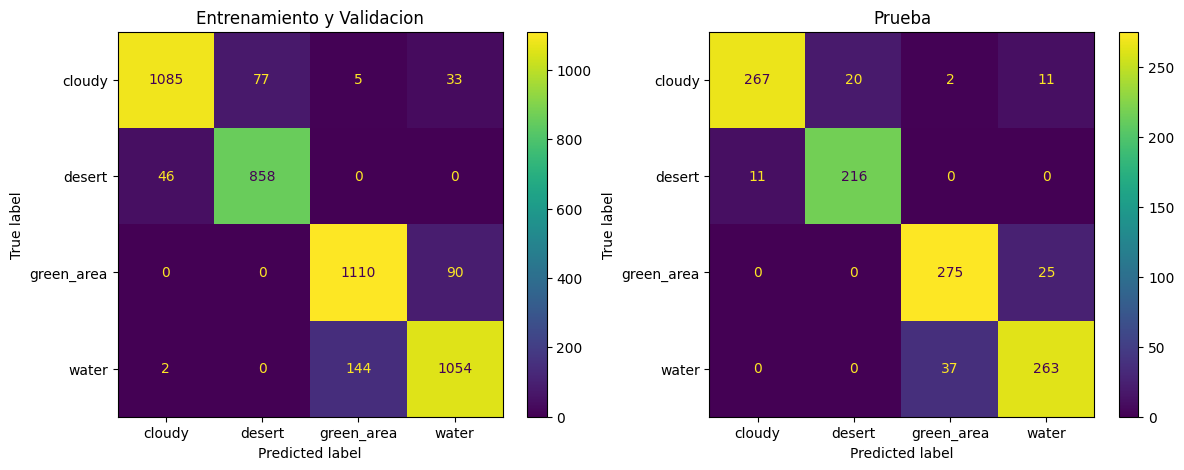

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

print("\nENTRENAMIENTO Y VALIDACION:\n")

y_pred = np.argmax(modelo.predict(X_train), axis=1)

print(classification_report(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_train,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax1
)
ax1.set_title("Entrenamiento y Validacion")

print("\nPRUEBA:\n")

y_pred = np.argmax(modelo.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax2
)
ax2.set_title("Prueba")

plt.show()

# 7. Predicciones futuras

el metodo `predict` nos devuelve un array con la probabilidad de que el input pertenezca a cada clase, para obtener la clase a la que tiene mayor probabilidad usamos `np.argmax(prediccion, axis=1)`

In [ ]:
modelo.predict(X_test[0:2,:,:,:])

1/1 [==============================] - 0s 114ms/step


array([[1.6037117e-07, 9.9999988e-01, 0.0000000e+00, 0.0000000e+00],
       [3.5419336e-07, 2.1607023e-14, 9.8671591e-01, 1.3283724e-02]],
      dtype=float32)

In [ ]:
np.argmax(modelo.predict(X_test[0:2,:,:,:]), axis=1)

1/1 [==============================] - 0s 175ms/step


array([2, 3])

In [ ]:
def plot_imagen_classification(modelo, imagen, clases, y_true=None):
    if len(imagen.shape) == 3:
        imagen = np.expand_dims(imagen, axis=0)

    predictions = modelo.predict(imagen)
    predicted_class = np.argmax(predictions)

    fig, (img_ax, prob_ax) = plt.subplots(1, 2, figsize=(10,5))

    img_ax.imshow(imagen[0])

    img_ax.xaxis.set_tick_params(labelbottom=False)
    img_ax.yaxis.set_tick_params(labelleft=False)
    img_ax.set_xticks([])
    img_ax.set_yticks([])

    prob_ax.bar(clases, predictions[0], label="otras clases", color="blue")
    prob_ax.bar(clases[predicted_class], predictions[0, predicted_class], label=f"predicha ({clases[predicted_class]})", color="red")

    if y_true != None:
        prob_ax.bar(clases[y_true], predictions[0, y_true], label=f"verdadera ({clases[y_true]})", color="green")

    prob_ax.legend()
    prob_ax.set_ylabel("probabilidad")

    plt.show()

1/1 [==============================] - 0s 58ms/step


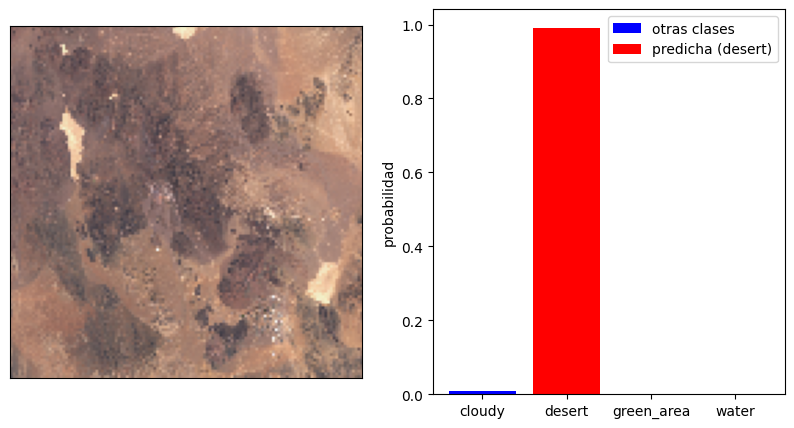

1/1 [==============================] - 0s 22ms/step


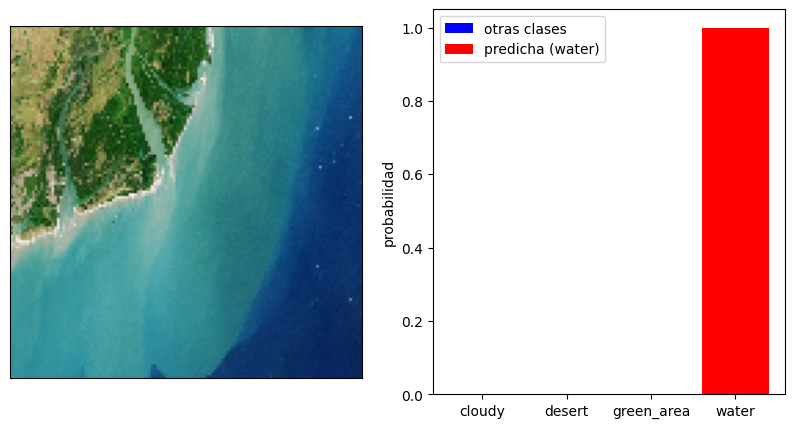

1/1 [==============================] - 0s 22ms/step


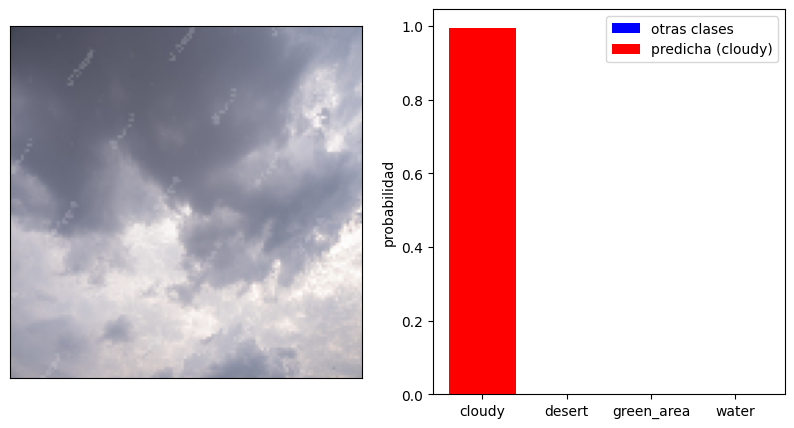

1/1 [==============================] - 0s 18ms/step


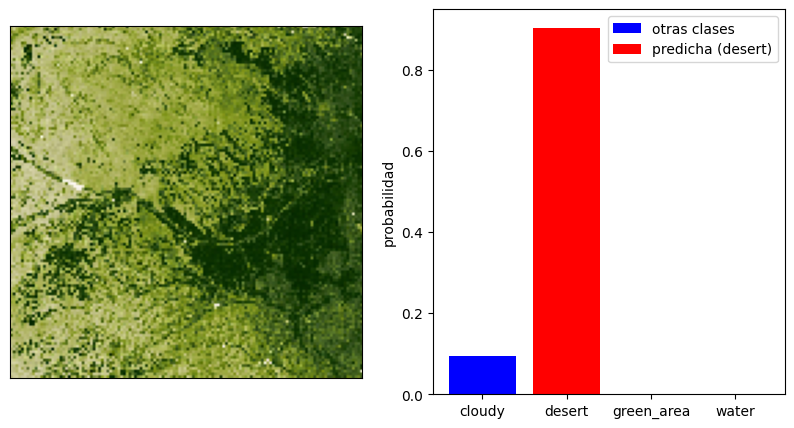

In [ ]:
import requests
import tempfile

url_list = ['https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg',
            'https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop',
            'https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000',
            'https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg',
]

for url in url_list:
    response = requests.get(url)

    with tempfile.NamedTemporaryFile() as f:
        f.write(response.content)
        f.seek(0)

        imagen = tf.keras.preprocessing.image.load_img(
            path = f.name,
            color_mode = "rgb",
            target_size = (128, 128)
        )
        imagen = tf.keras.preprocessing.image.img_to_array(imagen) / 255

        plot_imagen_classification(modelo, imagen, clases)



# 8. Transfer learning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (128, 128, 3)
)
base_model.trainable = False

input = tf.keras.Input((128, 128, 3))
x = base_model(input)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(50, activation='relu')(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)
output = tf.keras.layers.Dense(4, activation="softmax")(x)

transfer_learning_model = tf.keras.Model(input, output)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# ALGUNOS MODELOS PREENTRENADOS VIENEN CON UNA FUNCION preprocess_input que hace transformaciones
# a los datos de entrada necesarios para que el modelo tenga buen desempeño
from tensorflow.keras.applications.vgg16 import preprocess_input

X_processed = preprocess_input(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.2, stratify=y)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
transfer_learning_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                409650    
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 4)                 84        
                                                                 
Total params: 15,125,442
Trainable params: 410,754
Non-trai

In [ ]:
transfer_learning_model.compile(optimizer="adam",
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

CB = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
]

history = transfer_learning_model.fit(
    train_data_augmenter.flow(X_train, y_train, subset="training"),
    validation_data = train_data_augmenter.flow(X_train, y_train, subset="validation"),
    validation_split=0.2,
    epochs = 15,
    callbacks = CB,
    batch_size = 32,
    validation_batch_size = 32
)

Epoch 1/15
106/106 [==============================] - 35s 226ms/step - loss: 1.0644 - accuracy: 0.5423 - val_loss: 0.6463 - val_accuracy: 0.9325
Epoch 2/15
106/106 [==============================] - 22s 204ms/step - loss: 0.4749 - accuracy: 0.8582 - val_loss: 0.2901 - val_accuracy: 0.9547
Epoch 3/15
106/106 [==============================] - 23s 215ms/step - loss: 0.2891 - accuracy: 0.9118 - val_loss: 0.2095 - val_accuracy: 0.9361
Epoch 4/15
106/106 [==============================] - 20s 188ms/step - loss: 0.2082 - accuracy: 0.9340 - val_loss: 0.1759 - val_accuracy: 0.9440
Epoch 5/15
106/106 [==============================] - 21s 201ms/step - loss: 0.1728 - accuracy: 0.9426 - val_loss: 0.1262 - val_accuracy: 0.9671
Epoch 6/15
106/106 [==============================] - 26s 244ms/step - loss: 0.1602 - accuracy: 0.9440 - val_loss: 0.1363 - val_accuracy: 0.9609
Epoch 7/15
106/106 [==============================] - 20s 188ms/step - loss: 0.1438 - accuracy: 0.9535 - val_loss: 0.1354 - val_ac

### graficar evolucion en cada epoch del accuracy y la funcion de perdida durante el entrenamiento

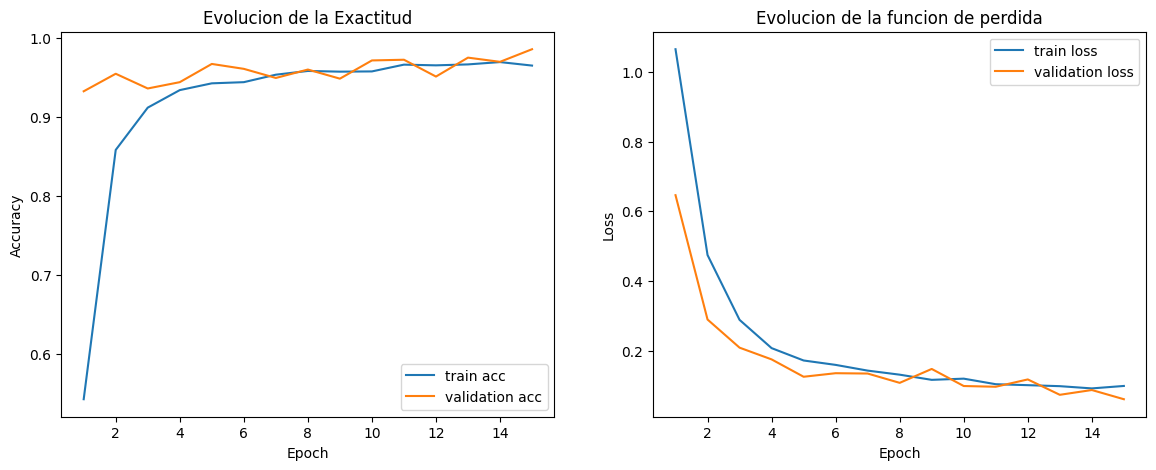

In [ ]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

### graficar matrices de confusion y reporte de metricas


ENTRENAMIENTO Y VALIDACION:

141/141 [==============================] - 7s 48ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1200
           1       0.93      1.00      0.96       904
           2       0.99      0.98      0.98      1200
           3       0.97      0.98      0.98      1200

    accuracy                           0.97      4504
   macro avg       0.97      0.97      0.97      4504
weighted avg       0.97      0.97      0.97      4504


PRUEBA:

36/36 [==============================] - 2s 58ms/step
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       300
           1       0.88      1.00      0.93       227
           2       0.97      0.99      0.98       300
           3       0.98      0.96      0.97       300

    accuracy                           0.95      1127
   macro avg       0.95      0.96      0.95      1127
weighted avg       0.96      0.95  

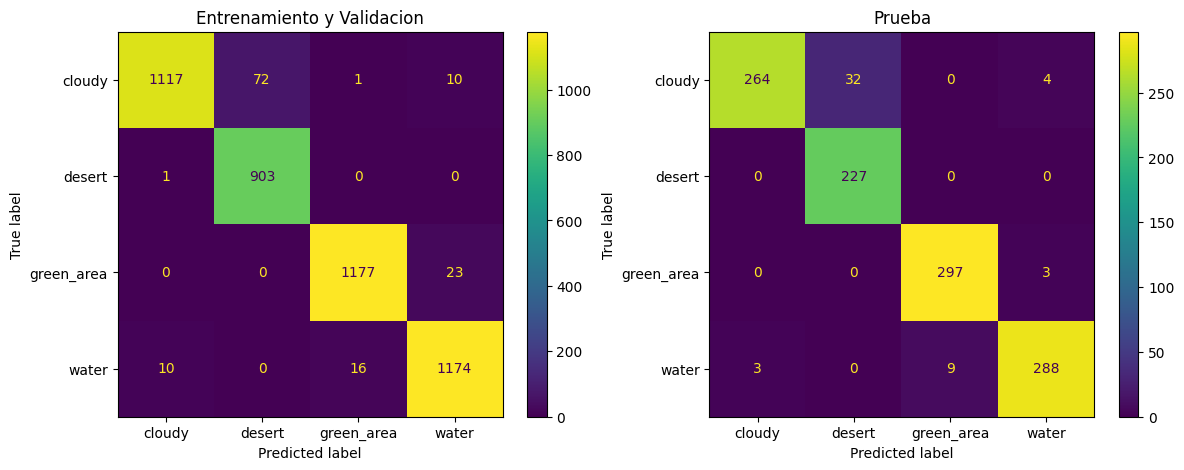

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

print("\nENTRENAMIENTO Y VALIDACION:\n")

y_pred = np.argmax(transfer_learning_model.predict(X_train), axis=1)

print(classification_report(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_train,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax1
)
ax1.set_title("Entrenamiento y Validacion")

print("\nPRUEBA:\n")

y_pred = np.argmax(transfer_learning_model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax2
)
ax2.set_title("Prueba")

plt.show()

1/1 [==============================] - 0s 424ms/step


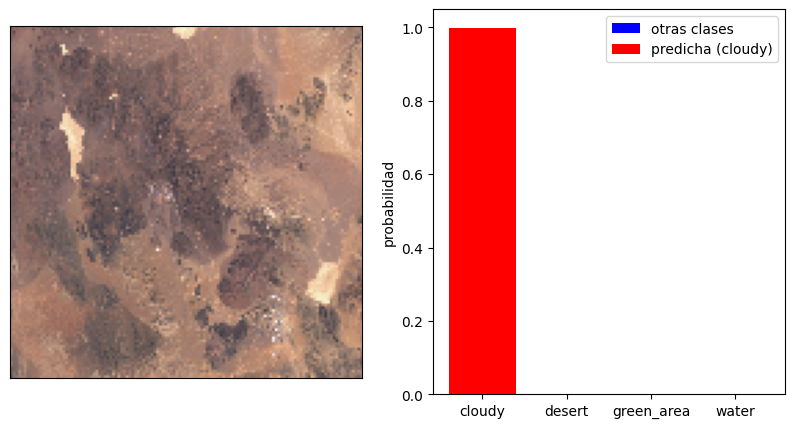

1/1 [==============================] - 0s 22ms/step


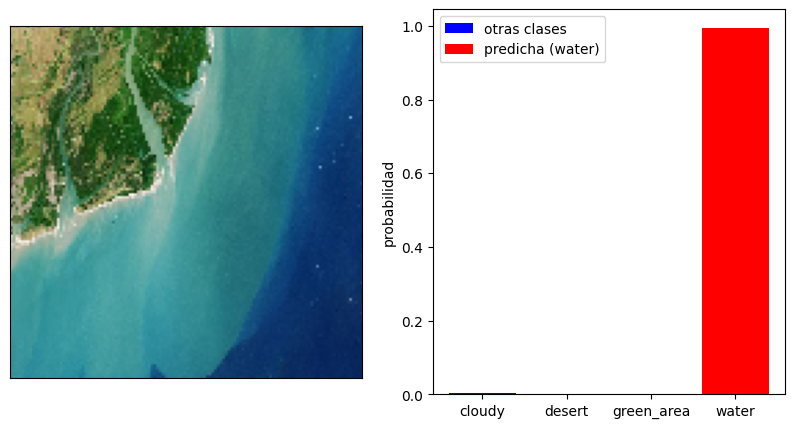

1/1 [==============================] - 0s 20ms/step


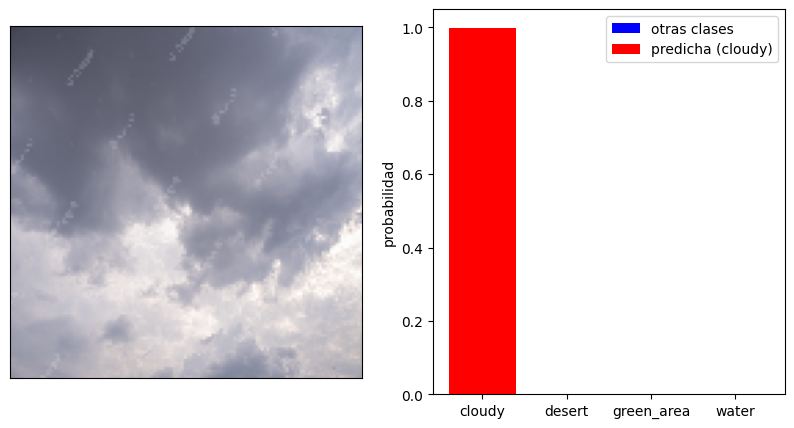

1/1 [==============================] - 0s 20ms/step


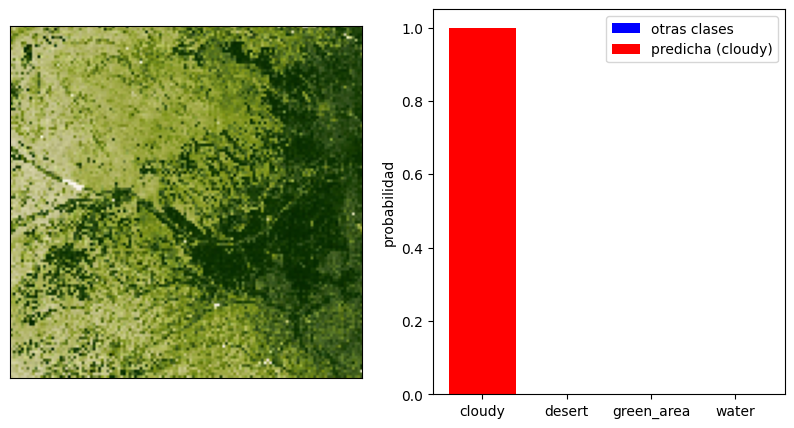

In [ ]:
import requests
import tempfile

url_list = ['https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg',
            'https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop',
            'https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000',
            'https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg',
]

for url in url_list:
    response = requests.get(url)

    with tempfile.NamedTemporaryFile() as f:
        f.write(response.content)
        f.seek(0)

        imagen = tf.keras.preprocessing.image.load_img(
            path = f.name,
            color_mode = "rgb",
            target_size = (128, 128)
        )
        imagen = tf.keras.preprocessing.image.img_to_array(imagen) / 255

        plot_imagen_classification(transfer_learning_model, imagen, clases)

